In [1]:
## SECTION 1: IMPORT AND IMPORT FROM PACKAGES

In [1]:
# Standard
import numpy as np
from numpy.random import seed
seed(440232650)
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

# I haven't installed tensorflow so can't import this?
from tensorflow import set_random_seed
set_random_seed(440232650)

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import random, cv2, h5py, requests
import np_utils
from glob import glob
from PIL import Image
from io import BytesIO
from itertools import chain

In [2]:
# Segmentation Models
import segmentation_models as sm
from segmentation_models import Unet, get_preprocessing
from segmentation_models.losses import jaccard_loss, dice_loss, binary_focal_loss, categorical_focal_loss, binary_crossentropy, categorical_crossentropy, bce_dice_loss, bce_jaccard_loss, cce_dice_loss, cce_jaccard_loss, binary_focal_dice_loss, binary_focal_jaccard_loss, categorical_focal_dice_loss, categorical_focal_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [3]:
# SKLearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, jaccard_score

In [4]:
# Keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D, Conv2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Activation
from keras.optimizers import Adam, SGD, Adagrad, Adadelta
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.utils import to_categorical

In [5]:
# Albumentations
from albumentations import (Compose,
    HorizontalFlip,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [6]:
## SECTION 2: DEFINE VARIABLES

In [7]:
# Weight initialisation
weight_initialisation = 'RI'    # randomly initialised

In [8]:
# Class distinction
class_dict = {0: 'SB'}

In [10]:
# Model variables
backbone = 'vgg16'
image_size = 256    # call image size for both h and w
classes = 1
batch_size = 2
epochs = 2

    # RI: None, TL: imagenet
encoder_weights = None 
    # RI: False, TL: True
encoder_freeze = False 

    # Activation - CHOOSE 1
activation = 'sigmoid'   # use for binary 
#activation = 'softmax'
#activation = 'linear'

    # Batch normalisation - CHOOSE 1
#decoder_use_batchnorm = True    #BatchNorm layer between Conv2D and Activation
decoder_use_batchnorm = False

In [11]:
# Loss Functions - CHOOSE 1
#loss = sm.losses.JaccardLoss()
#loss = sm.losses.DiceLoss()
loss = sm.losses.BinaryFocalLoss()
#loss = sm.losses.CategoricalFocalLoss()
#loss = sm.losses.BinaryCELoss()
#loss = sm.losses.CategoricalCELoss()

# Loss name - CHOOSE 1
#loss_name = 'JaccardLoss'
#loss_name = 'DiceLoss'
loss_name = 'BinaryFocalLoss'
#loss_name = 'CategoricalFocalLoss'
#loss_name = 'BinaryCELoss'
#loss_name = 'CategoricalCELoss'

In [40]:
# Optimiser parameters 
learning_rate = 0.0001
beta_1 = 0.9
beta_2 = 0.999
momentum = 0.0

# Optimiser - CHOOSE 1
opt = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
#opt = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)
#opt = Adagrad()                # recommended to leave defaults
#opt = Adadelta()               # recommends to leave defaults

In [41]:
# Performance
    # can specify threhsold=0.5
IOU = sm.metrics.IOUScore()
FScore = sm.metrics.FScore()
metrics=[IOU, FScore]

In [42]:
# Augmentations Performed? - CHOOSE 1
#da = 'dAug'
da = 'no_dAug'

In [43]:
## SECTION 3: DEFINE PATHS

In [44]:
# Training
ytrain_dir = 'Masks/1Train'
xtrain_dir = 'Images/1Train'

# Validation
yval_dir = 'Masks/1Val'
xval_dir = 'Images/1Val'

# Test
ytest_dir = 'Masks/1Test'
xtest_dir = 'Images/1Test'

# Save Path
save_path = f'Unet.{backbone}.w{weight_initialisation}.b{batch_size}.e{epochs}.lr{learning_rate}.{da}'

# Path where resulting weights will be saved
weights_path = (f'Weights/{save_path}.h5')

# Path where training log will be saved
training_log = f'TrainingLog/{save_path}.out'

# Define number of val/test images. If no. val images /= no. test images, need to create own generators with their own batch numbers
batch_size_val_test = len(os.listdir(xval_dir))

In [45]:
# Check how many images are in the folders 
print('Train Images & Masks')
print(len(os.listdir(xtrain_dir)))
print(len(os.listdir(ytrain_dir)))

print('Val Images & Masks')
print(len(os.listdir(xval_dir)))
print(len(os.listdir(yval_dir)))

print('Test Images & Masks')
print(len(os.listdir(xtest_dir)))
print(len(os.listdir(ytest_dir)))

Train Images & Masks
16
16
Val Images & Masks
4
4
Test Images & Masks
4
4


In [46]:
## SECTION 4: AUGMENTATIONS
    # comment out if not doing augmentations

In [47]:
#aug = Compose([OneOf([ElasticTransform(p=1, alpha=200, sigma=200 * 0.05, alpha_affine=200 * 0.03),GridDistortion(p=1, border_mode=0, value=5)], p=0.8), CLAHE(p=0.8),HorizontalFlip(p=0.5), RandomBrightnessContrast(p=0.8), RandomGamma(p=0.8)])

In [48]:
## SECTION 5: DATA GENERATOR FUNCTION - training + validation

In [49]:
# img_folder and mask_folder will be replaced with xtrain_dir/xval_dir and ytrain_dir/yval_dir when data generated in Section 7
def data_gen(img_folder, mask_folder, batch_size=batch_size, image_size=image_size, classes=classes):
    c=0
    n=os.listdir(img_folder)
    random.shuffle(n)
    
    while (True):
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        for i in range(c, c+batch_size):
            
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)         
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            
            # comment this out if not augmenting
            #augmented = aug(image=train_img, mask=train_mask)
            #train_img = augmented['image']
            #train_mask = augmented['mask']
            
            train_img = cv2.resize(train_img, (image_size, image_size))/255.     #change if image size changes
            train_img = train_img.reshape([image_size, image_size,1])
            
            img[i-c] = train_img #add to array img[0] img [1] etc
            
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            mask[i-c] = train_mask
            
        c+=batch_size
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
        
        yield img, mask

In [50]:
## SECTION 6: DATA GENERATOR FUNCTION - testing

In [51]:
# define batch_size as number of images in test folder (otherwise issuse with shuffling)
def test_gen(img_folder, mask_folder, batch_size=batch_size_val_test, image_size=image_size, classes=classes):
    c=0
    n=os.listdir(img_folder)
    n.sort() #always evaluate in the same order 
    #remove shuffling
    
    while (True):
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        for i in range(c, c+batch_size):
            
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE) 
            train_img = cv2.resize(train_img, (image_size, image_size))/255.     #change if image size changes
            train_img = train_img.reshape([image_size, image_size,1])
            
            img[i-c] = train_img #add to array img[0] img [1] etc
           
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE) 
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            #train_mask = train_mask.ravel()
            #train_mask = to_categorical(train_mask, num_classes=classes)
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            mask[i-c] = train_mask
            
        c+=batch_size
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
        
        yield img, mask

In [52]:
## SECTION 7: GENERATE THE DATA

In [53]:
# Generate training data (known)
train_gen = data_gen(xtrain_dir, ytrain_dir, image_size=image_size, batch_size=batch_size)

# Generate validation data (known)
val_gen = data_gen(xval_dir, yval_dir, image_size=image_size, batch_size=batch_size)

# Predicted generation for testing only -->
    # Generate predicted validation data (predictions)
    # update batch number so it matches house many images there are in the folder 
val_pred_generator = test_gen(xval_dir, yval_dir, image_size=image_size, batch_size=batch_size_val_test)

    # Generate test data (predicted)
    # update batch number so it matches house many images there are in the folder 
test_generator = test_gen(xtest_dir, ytest_dir, image_size=image_size, batch_size=batch_size_val_test)

In [54]:
## SECTION 8: DEFINE MODEL CALLBACKS
    # turn on/off as needed
    # can add verbose=1 if want to visualise progress bar

In [55]:
# Checkpoint - save minimum val_loss found
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# CSVLogger - save epoch results with "save_path" naming attached
csv_logger = CSVLogger(training_log, append=True, separator=';')

# EarlyStopping - stop training if val_loss doesn't improve after # epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode="min", patience=10, verbose=1)
                      
# Reduce Learning Rate - reduce learning rate if val_loss stops improving
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=5, min_lr=0.001, verbose=1)


# Collate callbacks 
callbacks_list = [checkpoint, csv_logger]

In [56]:
## SECTION 9: CREATE MODEL

In [57]:
model = Unet(backbone_name=backbone, encoder_weights=encoder_weights, classes=classes, activation=activation, 
        encoder_freeze=encoder_freeze, decoder_use_batchnorm = decoder_use_batchnorm, input_shape=(image_size, image_size, 1))

In [58]:
## SECTION 10: COMPILE MODEL

In [59]:
model.compile(optimizer=opt, loss=loss, metrics=metrics) 

In [60]:
# Model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [61]:
## SECTION 11: BEGIN TRAINING

In [62]:
# Define number of training and validation images
no_training_images = len(os.listdir(xtrain_dir))
no_val_images = len(os.listdir(xval_dir))
no_test_images = len(os.listdir(xtest_dir))

In [63]:
# Check that the steps will work - images/batch must be >= epochs

    # Training
print('Training')
print(no_training_images)
print(batch_size)
print(no_training_images//batch_size)

    # Validation
print('Val')
print(no_val_images)
print(batch_size)
print(no_val_images//batch_size)

    # Testing
print('Test')
print(no_test_images)
print(batch_size)
print(no_test_images//batch_size)

Training
16
2
8
Val
4
2
2
Test
4
2
2


In [64]:
# Train the model
results = model.fit_generator(train_gen, epochs=epochs, 
    # augmentation doesn't increase # images, so if augmenting, update # for steps_per_epoch to match correct # of images being trained on)
           steps_per_epoch = (no_training_images*1//batch_size),    
           validation_data=val_gen,
           validation_steps=(no_val_images//batch_size), 
           verbose=1, callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/2
8/8 [==============================] - 10s 1s/step - loss: -56.7427 - iou_score: 4.1569 - f1-score: 1.3156 - val_loss: -181.1445 - val_iou_score: 6.6610 - val_f1-score: 1.7389

Epoch 00001: val_loss improved from inf to -181.14452, saving model to Weights/Unet.vgg16.wRI.b2.e2.lr0.0001.no_dAug.h5
Epoch 2/2
8/8 [==============================] - 9s 1s/step - loss: -487.1099 - iou_score: 16.2877 - f1-score: 1.8736 - val_loss: -179.9090 - val_iou_score: 6.3954 - val_f1-score: 1.7293

Epoch 00002: val_loss did not improve from -181.14452


In [377]:
## SECTION 12: PLOT TRAINING RESULTS

In [378]:
# Load model
#model = load_model(f'Models/{save_path}.hdf5')

In [379]:
# Save model weights
#model.save_weights(f'Weights/{save_path}.h5')

In [405]:
# Read the TrainingLog data for plotting
history = pd.read_csv(training_log, sep=';')

In [406]:
# Create function to plot training and validation IOU score and loss values
    # to save plot data: save = True, name = save_path
def plot_history(history, save=True, name=save_path):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.plot(history['iou_score'])
    ax1.plot(history['val_iou_score'])
    ax1.title.set_text('Model Accuracy')
    ax1.set_ylabel('Jaccard Score')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss values
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.title.set_text('Model loss')
    ax2.set_ylabel('Jaccard Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.show()
    if save==False:
        return
    else:
        fig.savefig(f'Figures/{name}.png')      
    return

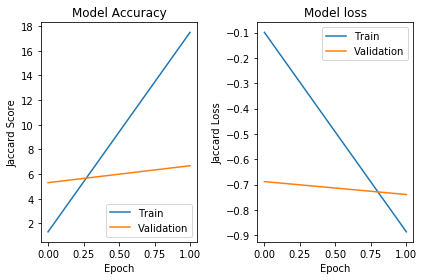

In [407]:
# Show the plots
    # to save plot figures: save = True, name = save_path
plot_history(history, save = True, name = save_path)

In [408]:
## SECTION 13: MODEL EVALUATION
    # only call when testing

In [409]:
# Define the function to get the model scores
def get_class_jaccard(image_folder, mask_folder, generator):
    image_names = os.listdir(image_folder)
    image_names.sort()
    
    predictions = model.predict_generator(generator, steps=1)
    
    ytrue = np.zeros((batch_size_val_test, image_size, image_size, classes)).astype('float')
    
    for i in range(batch_size_val_test):
        target = cv2.imread(os.path.join(mask_folder, image_names[i]), cv2.IMREAD_GRAYSCALE)
        target = cv2.resize(target, (image_size, image_size))
        target = target.reshape([image_size, image_size, classes])
        
        ytrue[i] = target
        
    ypred = np.argmax(predictions, axis=-1)
    ytrue = np.argmax(ytrue, axis=-1)
    
    scores = jaccard_score(ytrue.ravel(), ypred.ravel(), average=None)
    
    return print(f'SB: {scores[0]}')

In [410]:
# Show validation prediction scores
get_class_jaccard(xval_dir, yval_dir, val_pred_generator)

SB: 1.0


In [411]:
# Show test scores
get_class_jaccard(xtest_dir, ytest_dir, test_generator)

SB: 1.0


In [443]:
## SECTION 14: VISUALISE VALIDATION PREDICTIONS

In [444]:
# Get val image names and match with predictions
image_names = os.listdir(xval_dir)
image_names.sort()
predictions = model.predict_generator(val_pred_generator, steps=1)
ypred = np.argmax(predictions, axis=-1)

In [445]:
# Create function to image validation predictions
def plot_pred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join(xval_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))
    
    target = cv2.imread(os.path.join(yval_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap='plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU SB: {round(scores[0]*100,2)}', (image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/{save_path}_{image_names[index]}.png')
        
    plt.show()

In [446]:
# Get the val predictions shape (number of images x h x w x channels)
predictions.shape

(4, 256, 256, 1)

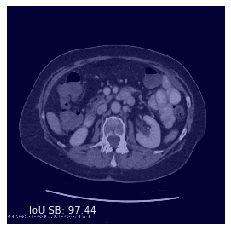

In [447]:
# Show the prediction
    # first integer is image number, starting at 0
plot_pred(2, ypred, save=True)

In [448]:
## SECTION 15: VISUALISE TEST PREDICTIONS

In [449]:
# Get test image names and match with predictions
image_names = os.listdir(xtest_dir)
image_names.sort()
predictions = model.predict_generator(test_generator, steps=1)
ypred = np.argmax(predictions, axis=-1)

In [450]:
# Create function to image test predictions
def plot_testpred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join(xtest_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))
    
    target = cv2.imread(os.path.join(ytest_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap='plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU SB: {round(scores[0]*100,2)}', (image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/TestFigures/{save_path}_{image_names[index]}.png')
        
    plt.show()

In [451]:
# Get the test predictions shape (number of images x h x w x channels)
predictions.shape

(4, 256, 256, 1)

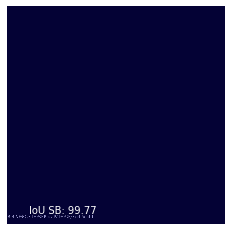

In [452]:
# Show the test predictions
    # first integer is image number, starting at 0 
plot_testpred(0, ypred, save=False)